## Essai du modèle EfficientNet3b avec poids de classe, transfer learning et désactivation des dernières couches

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import os
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M, preprocess_input
import tensorflow_addons as tfa # deprecated (see warning below), but cannot use F1Score from tensorflow.keras.metrics 
# because it is only available in newest versions of tensorflow, which are not usable as for now (may 2024) on Mac computers. 
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from plot_keras_history import show_history, plot_history
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom

from sklearn.metrics import classification_report

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're usin

### Chargement des images

In [3]:
train_set_path = "./data/images/images/train_sorted_images/"
val_set_path = "./data/images/images/val_sorted_images/"

In [4]:
label_names = ['10', '40', '50', '60', '1140', '1160', '1180', '1280', '1281', '1300', '1301', '1302', '1320', '1560', 
          '1920', '1940', '2060', '2220', '2280', '2403', '2462', '2522', '2582', '2583', '2585', '2705', '2905']

train_set = tf.keras.utils.image_dataset_from_directory(
        train_set_path, labels='inferred', label_mode='categorical', class_names=label_names, 
        batch_size = 32, image_size=(224, 224), shuffle=True, seed=42, validation_split=None, subset=None
    )
val_set = tf.keras.utils.image_dataset_from_directory(
        val_set_path, labels='inferred', label_mode='categorical', class_names=label_names, 
        batch_size = 32, image_size=(224, 224), shuffle=False, seed=42, validation_split=None, subset=None
    )

Found 54346 files belonging to 27 classes.


2024-06-09 08:59:40.261328: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 08:59:40.964137: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22128 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c1:00.0, compute capability: 8.9


Found 13587 files belonging to 27 classes.


### Preprocessing sur images et poids de classe

In [5]:
data_augmentation = Sequential([
    RandomFlip("horizontal", input_shape=(224, 224, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1)
])

def preprocess(image, label):
    image = preprocess_input(image)
    return image, label

# Appliquer les transformations
train_set = train_set.map(lambda x, y: (data_augmentation(x, training=True), y))
train_set = train_set.map(preprocess)

In [6]:
def get_labels(dataset):
    dataset = dataset.unbatch().batch(128)
    all_labels = []
    for batch in dataset:
        images, labels = batch
        all_labels.extend(np.argmax(labels.numpy(), axis=1))
    return np.array(all_labels)

train_labels = get_labels(train_set)
val_labels = get_labels(val_set)
train_original_labels = [label_names[i] for i in train_labels]
val_original_labels = [label_names[i] for i in val_labels]

In [7]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_labels), 
                                     y=train_labels)

class_weights = dict(enumerate(class_weights))
print("Poids de classe :", class_weights)

Poids de classe : {0: 1.0089297317367494, 1: 1.25409022729895, 2: 1.8706457386754785, 3: 3.7763880202904594, 4: 1.1770846870262075, 5: 0.7955789781876739, 6: 4.1161857153677195, 7: 0.6457538706496038, 8: 1.5191055206149546, 9: 0.6233554706766228, 10: 3.8932588294290422, 11: 1.2627445513267346, 12: 0.9704989463909426, 13: 0.6200908240341388, 14: 0.7311350580511495, 15: 3.9159821299899122, 16: 0.6299889874224772, 17: 3.8193829503127414, 18: 0.660805914253058, 19: 0.658859186518761, 20: 2.211884411884412, 21: 0.6303835937409379, 22: 1.2147343481079147, 23: 0.30809961959510407, 24: 1.2595837389329254, 25: 1.1391142132511685, 26: 3.6071950086287004}


### Modele avec poids de classe, transfer learning et reactivation des dernieres couches

#### Entrainement du modele sans activation des couches avec 5 epoch et un learning rate de 0.01

In [71]:
base = EfficientNetB3(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

for layer in base.layers:
    layer.trainable = False

model = Sequential([
    base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(27, activation='softmax')
])
lr = 0.01 
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [72]:
history = model.fit(
    train_set,
    epochs=5,
    validation_data=val_set,
    class_weight=class_weights
)

Epoch 1/5
1699/1699 [==============================] - 489s 284ms/step - loss: 3.0234 - accuracy: 0.2177 - val_loss: 2.4170 - val_accuracy: 0.3560
Epoch 2/5
1699/1699 [==============================] - 481s 283ms/step - loss: 2.9792 - accuracy: 0.2134 - val_loss: 2.6154 - val_accuracy: 0.3425
Epoch 3/5
1699/1699 [==============================] - 480s 283ms/step - loss: 2.9799 - accuracy: 0.2064 - val_loss: 2.6747 - val_accuracy: 0.3146
Epoch 4/5
1699/1699 [==============================] - 479s 282ms/step - loss: 2.9402 - accuracy: 0.2070 - val_loss: 2.8096 - val_accuracy: 0.3043
Epoch 5/5
1699/1699 [==============================] - 483s 284ms/step - loss: 2.9364 - accuracy: 0.2124 - val_loss: 2.8399 - val_accuracy: 0.2970


#### Maintenant que le modele est un peu entrainé avec les couches denses que l'on a ajoutées, on reactive les 50 dernieres couches du modele pre-entrainé et on l'entraine sur 40 epochs avec un learning rate plus faible

In [76]:
base.trainable = True
for layer in base.layers[:-50]:  
    layer.trainable = False

lr = 0.0001 
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=[tfa.metrics.F1Score(num_classes=27, average="weighted"), 
                                                                          "accuracy"])

In [77]:
history = model.fit(
    train_set,
        epochs=50,
    validation_data=val_set,
    class_weight=class_weights
)

Epoch 1/10
1699/1699 [==============================] - 488s 283ms/step - loss: 3.5748 - f1_score: 0.2081 - accuracy: 0.1668 - val_loss: 2.3609 - val_f1_score: 0.3687 - val_accuracy: 0.3227
Epoch 2/10
1699/1699 [==============================] - 485s 285ms/step - loss: 2.6267 - f1_score: 0.2744 - accuracy: 0.2280 - val_loss: 2.2018 - val_f1_score: 0.4062 - val_accuracy: 0.3672
Epoch 3/10
1699/1699 [==============================] - 484s 285ms/step - loss: 2.5013 - f1_score: 0.3035 - accuracy: 0.2575 - val_loss: 2.0712 - val_f1_score: 0.4375 - val_accuracy: 0.4086
Epoch 4/10
1699/1699 [==============================] - 487s 286ms/step - loss: 2.3997 - f1_score: 0.3255 - accuracy: 0.2855 - val_loss: 1.9949 - val_f1_score: 0.4629 - val_accuracy: 0.4381
Epoch 5/10
1699/1699 [==============================] - 480s 282ms/step - loss: 2.3039 - f1_score: 0.3465 - accuracy: 0.3103 - val_loss: 1.9525 - val_f1_score: 0.4743 - val_accuracy: 0.4557
Epoch 6/10
1699/1699 [============================

#### Resultats

In [17]:
model.evaluate(val_set)

107/107 [==============================] - 16s 140ms/step - loss: 1.7351 - f1_score: 0.6217 - accuracy: 0.6122


[1.73512864112854, 0.6217286586761475, 0.6122028231620789]

In [33]:
y_pred = np.array(model.predict(val_set, verbose=False))

In [34]:
y_pred = np.argmax(y_pred, axis=1)

In [35]:
y_true = val_labels

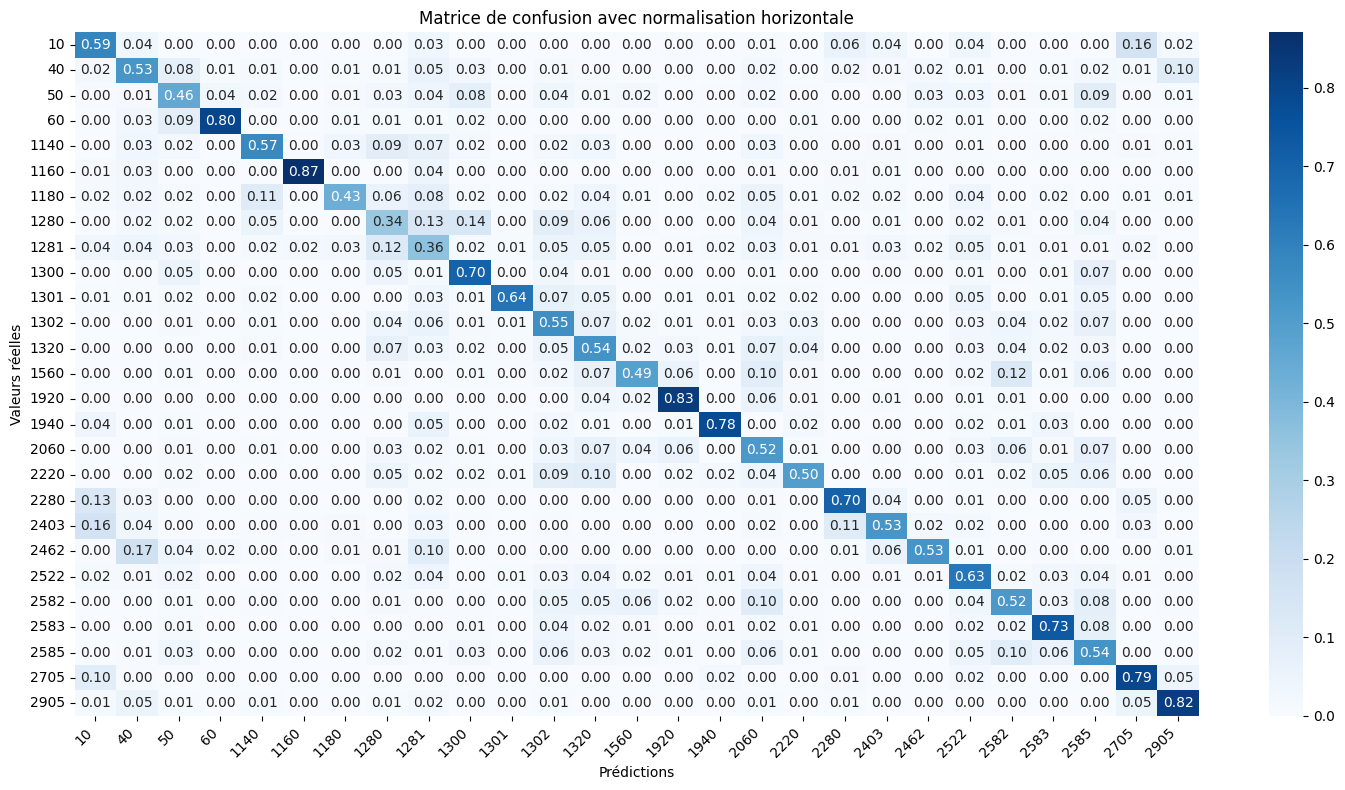

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_true, y_pred)
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(15, 8))
sns.heatmap(normalized_cm, annot=True, cmap='Blues', fmt='.2f', 
            xticklabels=label_names, yticklabels=label_names)

plt.title('Matrice de confusion avec normalisation horizontale')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()

plt.show()

In [37]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred , target_names=label_names)
print(report)

              precision    recall  f1-score   support

          10       0.48      0.59      0.53       499
          40       0.51      0.53      0.52       401
          50       0.36      0.46      0.40       269
          60       0.82      0.80      0.81       133
        1140       0.70      0.57      0.63       427
        1160       0.97      0.87      0.92       632
        1180       0.49      0.43      0.46       122
        1280       0.49      0.34      0.40       779
        1281       0.22      0.36      0.28       331
        1300       0.72      0.70      0.71       807
        1301       0.73      0.64      0.68       129
        1302       0.37      0.55      0.44       399
        1320       0.42      0.54      0.47       519
        1560       0.74      0.49      0.59       812
        1920       0.79      0.83      0.81       689
        1940       0.63      0.78      0.70       128
        2060       0.50      0.52      0.51       799
        2220       0.36    

In [14]:
model.save('tuned_transfer_learning_effi3b_weightclass.keras')
model.save('tuned_transfer_learning_effi3b_weightclass.h5')
model.save_weights('tuned_transfer_learning_effi3b_weightclass.weights.h5')

In [32]:
model = keras.models.load_model('tuned_transfer_learning_effi3b_weightclass.keras')

#### Grad Cam 

In [9]:
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

base_model = EfficientNetB3(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  
x = Dropout(0.5)(x)
outputs = Dense(27, activation='softmax')(x)  

model_for_grad_cam = Model(inputs=base_model.input, outputs=outputs)

lr = 0.01 
optimizer = Adam(learning_rate=lr)
loss = CategoricalCrossentropy()
model_for_grad_cam.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [10]:
model_for_grad_cam.fit(
    train_set,
    epochs=1,
    validation_data=val_set
)

2024-06-09 09:14:59.627502: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-06-09 09:15:00.538208: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-06-09 09:15:00.538281: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-06-09 09:15:00.538506: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


   1/1699 [..............................] - ETA: 4:24:09 - loss: 3.5026 - accuracy: 0.0000e+00

2024-06-09 09:15:01.434729: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1699/1699 [==============================] - 518s 300ms/step - loss: 2.5679 - accuracy: 0.3178 - val_loss: 2.2587 - val_accuracy: 0.4329


1/1 [==============================] - 0s 79ms/step
Categorie choisie :  1280


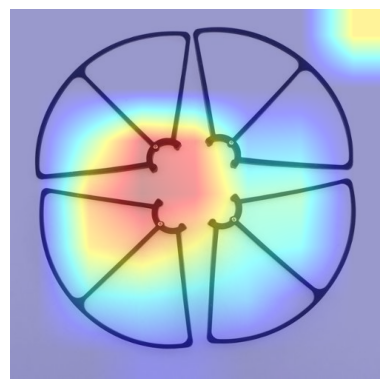

1/1 [==============================] - 0s 71ms/step
Categorie choisie :  1280


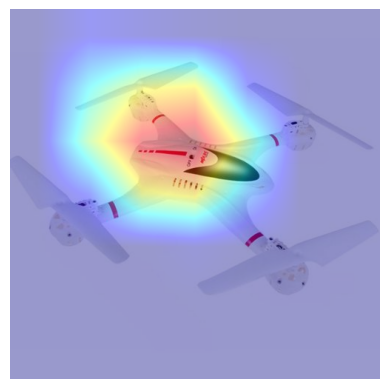

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2

def load_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

# Fonction pour générer la heatmap Grad-CAM
def get_grad_cam_heatmap(model, img_array, class_index, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]
    
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs[0]
    heatmap = np.dot(conv_outputs, pooled_grads[..., tf.newaxis])
    heatmap = tf.squeeze(heatmap)
    
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Fonction pour superposer la heatmap sur l'image d'origine
def superimpose_heatmap(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return superimposed_img


dict_label = {}

for i,l in enumerate(val_labels):
    dict_label[i] = l

def images_choice(img_dir , categ, nbre_images ):
    def images_retrieve(dir_path):
        img_names = []
        for root, _, filenames in os.walk(dir_path):
            for filename in filenames:
                img_names.append(os.path.join(root, filename))
        return img_names
    
    image_dir_val = img_dir
    image_names = None
    if categ:
        selected_subdir_path = os.path.join(img_dir, categ)
        if not os.path.isdir(selected_subdir_path):
            raise ValueError(f"Le sous-répertoire '{categ}' n'existe pas dans '{image_dir_val}'.")
        image_names = images_retrieve(selected_subdir_path)
    else:
        if not os.path.isdir(img_dir):
            raise ValueError(f"Le répertoire {image_dir_val} n'existe pas'.")
        image_names = images_retrieve(img_dir)
        
    return image_names[:nbre_images]

#parametres pour fonction images_choice
categorie_choisie = '1280'
nbre_images = 2

imgp1 ,imgp2 = images_choice(img_dir='./data/images/images/val_sorted_images' , categ=categorie_choisie,
                  nbre_images=nbre_images)

images_tab = images_choice(img_dir='./data/images/images/val_sorted_images' , categ=categorie_choisie,
                  nbre_images=nbre_images)


last_conv_layer_name = 'top_conv' 
model_to_test = model_for_grad_cam


for im in images_tab:
    img_path = im
    img_array = load_image(img_path)
    
    # Prédire la classe de l'image
    predictions = model_to_test.predict(img_array)
    class_index = np.argmax(predictions[0])
    
    # Générer la heatmap Grad-CAM
    heatmap = get_grad_cam_heatmap(model_to_test, img_array, class_index, last_conv_layer_name)
    
    # Superposer la heatmap sur l'image d'origine
    superimposed_img = superimpose_heatmap(img_path, heatmap)
    
    # Afficher l'image superposée
    print('Categorie choisie : ', categorie_choisie)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()